In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.wkt import loads

In [1]:
path = '/Data/'

- There are three types of data : race, censusTracts, tifs

In [3]:
# read in demographic data
race = pd.read_csv(path + '2017-2021_PP.csv')
race.drop(0, inplace = True)
race = gpd.GeoDataFrame(race)

race[['GEO_ID', 'NAME', 'POPGROUP_LABEL', 'B01003_001E']].head(3)

,GEO_ID,NAME,POPGROUP_LABEL,B01003_001E
1,1400000US17031010100,Census Tract 101; Cook County; Illinois,Total population,4534
2,1400000US17031010100,Census Tract 101; Cook County; Illinois,White alone or in combination with one or more...,2457
3,1400000US17031010100,Census Tract 101; Cook County; Illinois,Black or African American alone or in combinat...,1814


- 'race': geoid, population of each race

In [4]:
# read in census tract boundary data
censusTracts = gpd.read_file(path + 'Boundaries - Census Tracts - 2010.geojson') # as of 2018 <- this file contains shapely geometry data

censusTracts[['geoid10', 'geometry']].head(3)

,geoid10,geometry
0,17031842400,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ..."
1,17031840300,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ..."
2,17031841100,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ..."


- 'censusTracts': geoid, geometry

In [5]:
# read in tif data
tifs = pd.read_csv(path + '2019_TIF_Boundaries.csv') # as of 2024

tifs[['NAME', 'the_geom']].head(3)

,NAME,the_geom
0,Randolph/Wells,MULTIPOLYGON (((-87.63555699115906 41.88583481...
1,Midway Industrial Corridor,MULTIPOLYGON (((-87.73375151006204 41.81941950...
2,Stony Island/Burnside,MULTIPOLYGON (((-87.58465909552856 41.74230196...


- 'tifs': geometry of TIF district in certain year

## Calculate the overlapping area for each tif district with census tracts and get ratio of overlap. Using the ratio, we can get white, black, hispanic population inside each tif districts. Then finally, we can get averaged median income for each race

### 1. Fetch white, black, hispanic, total population from the 'race' file organized by geoid. This dictionary is 'demographic'

In [6]:
white_str = "White alone or in combination with one or more other races"
black_str = "Black or African American alone or in combination with one or more other races"
hispanic_str = "Hispanic or Latino (of any race)"

# Divide the dataframe 'race' into four sub dataframe containing data for each race
tot = race[race['POPGROUP_LABEL'] == 'Total population']
white = race[race['POPGROUP_LABEL'] == white_str]
black = race[race['POPGROUP_LABEL'] == black_str]
hispanic = race[race['POPGROUP_LABEL'] == hispanic_str]

In [7]:
# Save the ratial population according to geoid in a dictionary
# {geo_id : [total, white, black, hispanic]}

demographic = {}
geo_ids = sorted(set(np.array(race['GEO_ID'])))

for geo_id in geo_ids:
    tot_pop = int(np.array(race['B01003_001E'][race['GEO_ID'] == geo_id][race['POPGROUP_LABEL'] == 'Total population']))

    if geo_id in np.array(white['GEO_ID']):
        white_pop = int(np.array(race['B01003_001E'][race['GEO_ID'] == geo_id][race['POPGROUP_LABEL'] == white_str]))
    else:
        white_pop = 0

    if geo_id in np.array(black['GEO_ID']):
        black_pop = int(np.array(race['B01003_001E'][race['GEO_ID'] == geo_id][race['POPGROUP_LABEL'] == black_str]))
    else:
        black_pop = 0

    if geo_id in np.array(hispanic['GEO_ID']):
        hispanic_pop = int(np.array(race['B01003_001E'][race['GEO_ID'] == geo_id][race['POPGROUP_LABEL'] == hispanic_str]))
    else:
        hispanic_pop = 0
        
    geo_id = geo_id.split('US')[1]

    demographic[geo_id] = [tot_pop, white_pop, black_pop, hispanic_pop]

In [8]:
demographic

{'17031010100': [4534, 2457, 1814, 0],
 '17031010201': [8232, 3669, 3851, 2047],
 '17031010202': [3124, 1297, 1043, 0],
 '17031010300': [6085, 3264, 1907, 0],
 '17031010400': [4587, 3730, 0, 0],
 '17031010501': [4057, 2603, 0, 0],
 '17031010502': [2816, 1847, 0, 0],
 '17031010503': [2182, 1815, 0, 0],
 '17031010600': [6553, 4123, 1509, 0],
 '17031010701': [3646, 1954, 872, 1294],
 '17031010702': [5014, 2173, 2130, 1402],
 '17031020100': [3972, 1660, 1604, 1252],
 '17031020200': [7159, 4444, 0, 0],
 '17031020301': [5303, 4471, 0, 0],
 '17031020302': [5348, 3955, 0, 0],
 '17031020400': [4115, 2383, 945, 0],
 '17031020500': [6560, 2360, 1150, 0],
 '17031020601': [5937, 4235, 0, 0],
 '17031020602': [5823, 2888, 0, 0],
 '17031020701': [1728, 1359, 0, 0],
 '17031020702': [8659, 5641, 0, 2411],
 '17031020801': [6025, 3974, 0, 1633],
 '17031020802': [8514, 3623, 0, 0],
 '17031020901': [6237, 2735, 1827, 1539],
 '17031020902': [4517, 2136, 858, 751],
 '17031030101': [3699, 1894, 0, 0],
 '170310

### 2. Insert the demographic data into 'censusTract' dataframe

In [9]:
prefix = '1400000US'

geoids10 = np.array(censusTracts['geoid10'], dtype = '<U11')
geometries = [censusTracts.iloc[x:x+1]['geometry'].iloc[0] for x in range(len(censusTracts)-1)]
ssbb872200

race_geometry = []
county_not_chicago = []
for i in range(len(race)):
    idx = np.where(geoids10 == str(race.iloc[i]['GEO_ID'].split('US')[1]))
    try:
        race_geometry.append(geometries[idx[0][0]])
    except:
        county_not_chicago.append(i)

county_not_chicago = set(county_not_chicago)
county_not_chicago = list(county_not_chicago)

race.drop(county_not_chicago, inplace = True)

geoid10 = np.array(censusTracts['geoid10'])

total = []
white = []
black = []
latin = []

for id in geoid10:
    try:
        total.append(demographic[id][0])
        white.append(demographic[id][1])
        black.append(demographic[id][2])
        latin.append(demographic[id][3])
        
    except:
        total.append(None)
        white.append(None)
        black.append(None)
        latin.append(None)

censusTracts.insert(6, 'Total', total, True)
censusTracts.insert(6, 'White', white, True)
censusTracts.insert(6, 'Black', black, True)
censusTracts.insert(6, 'Latin', latin, True)

censusTracts.set_geometry('geometry', inplace = True)

In [10]:
censusTracts

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,Latin,Black,White,Total,notes,tractce10,countyfp10,geometry
0,17,8424,44,Census Tract 8424,44,17031842400,0.0,2906.0,0.0,3008.0,,842400,031,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ..."
1,17,8403,59,Census Tract 8403,59,17031840300,1874.0,0.0,1207.0,3668.0,,840300,031,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ..."
2,17,8411,34,Census Tract 8411,34,17031841100,0.0,0.0,0.0,7065.0,,841100,031,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ..."
3,17,8412,31,Census Tract 8412,31,17031841200,3396.0,0.0,2463.0,4455.0,,841200,031,"MULTIPOLYGON (((-87.68813 41.85569, -87.68816 ..."
4,17,8390,32,Census Tract 8390,32,17031839000,0.0,0.0,7129.0,10155.0,,839000,031,"MULTIPOLYGON (((-87.63312 41.87449, -87.63306 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,17,704,7,Census Tract 704,7,17031070400,0.0,0.0,2993.0,3420.0,,070400,031,"MULTIPOLYGON (((-87.65746 41.93258, -87.65722 ..."
797,17,705,7,Census Tract 705,7,17031070500,0.0,0.0,2914.0,3264.0,,070500,031,"MULTIPOLYGON (((-87.66349 41.93036, -87.66350 ..."
798,17,1303,13,Census Tract 1303,13,17031130300,1194.0,0.0,2961.0,5481.0,,130300,031,"MULTIPOLYGON (((-87.71436 41.98300, -87.71472 ..."
799,17,2922,29,Census Tract 2922,29,17031292200,0.0,2253.0,0.0,2580.0,,292200,031,"MULTIPOLYGON (((-87.71317 41.85523, -87.71357 ..."


### 3. For each TIF district, get the list of geoid of census tract that it overlaps with, and according population. Add it to the column of 'tifs' dataframe
- Assumed uniform population districution

In [11]:
tifs = gpd.GeoDataFrame(tifs)
tifs = tifs.rename(columns={'the_geom': 'geometry'})
tifs['geometry'] = loads(tifs['geometry'])
tifs.set_geometry('geometry', inplace = True)

def intersection_area(polygon1, polygon2):
    area = polygon1.intersection(polygon2).area
    return area/(1.0071444041535681* 10 ** - 11 * 43560) # return in acres

B = []; W = []; L = []; OI = []

censusTracts.dropna(inplace = True)

for idx1, geom1 in enumerate(tifs['geometry']):
    overlap_ids = []
    black = []
    white = []
    latin = []
    for idx2, geom2 in enumerate(censusTracts['geometry']):
        area = intersection_area(geom1, geom2)
        if area != 0:
            overlap_ids.append(prefix + str(censusTracts['geoid10'].iloc[idx2]))
            ratio = area/(geom2.area)*(1.0071444041535681* 10 ** - 11 * 43560)
            # print(ratio)
            black.append(int(int(censusTracts['Black'].iloc[idx2])*ratio))
            white.append(int(int(censusTracts['White'].iloc[idx2])*ratio))
            latin.append(int(int(censusTracts['Latin'].iloc[idx2])*ratio))
    
    B.append(black)
    W.append(white)
    L.append(latin)
    OI.append(overlap_ids)

    if len(overlap_ids) == 0:
            B.append(None)
            W.append(None)
            L.append(None)
            OI.append(None)
            print('!')

tifs.insert(4, 'Black', B, True)
tifs.insert(4, 'White', W, True)
tifs.insert(4, 'Latin', L, True)
tifs.insert(4, 'Overlap_ids', OI, True)

In [12]:
tifs

,geometry,OBJECTID_1,OBJECTID_2,OBJECTID,Overlap_ids,Latin,White,Black,NAME,REF,...,NAME_TRIM,SBIF,COMM_AREA,WARDS,REPEALED_D,APPROVAL_D,EXPIRATION,SHAPE_Leng,Shape_Le_1,Shape_Area
0,"MULTIPOLYGON (((-87.63556 41.88583, -87.63526 ...",1,1,0,[1400000US17031839100],[0],[142],[34],Randolph/Wells,T-172,...,Randolph/Wells,N,32,42,NaN,6/9/2010,12/31/2034,2930.444255,2930.444255,3.799572e+05
1,"MULTIPOLYGON (((-87.73375 41.81942, -87.73373 ...",2,2,0,"[1400000US17031835200, 1400000US17031560400, 1...","[991, 225, 272, 173, 0, 80, 339, 1022, 5, 99]","[766, 209, 224, 155, 0, 100, 355, 884, 5, 126]","[0, 0, 106, 0, 7, 0, 0, 0, 0, 0]",Midway Industrial Corridor,T- 89,...,Midway Industrial Corridor,Y,"56,57,62","13,14,23",NaN,2/16/2000,12/31/2024,41536.525279,41536.525279,1.670028e+07
2,"MULTIPOLYGON (((-87.58466 41.74230, -87.58465 ...",3,3,0,"[1400000US17031834300, 1400000US17031440102, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[338, 979, 12, 220, 684, 1601, 566, 352, 124, ...",Stony Island/Burnside,T- 54,...,Stony Island/Burnside,Y,"44,45,47,48,49,50,51","7,8,9",NaN,6/10/1998,12/31/2034,93968.295043,93968.295042,2.672080e+07
3,"MULTIPOLYGON (((-87.66943 41.97609, -87.66853 ...",7,7,0,"[1400000US17031031700, 1400000US17031031800, 1...","[0, 0, 0, 0, 0]","[618, 330, 186, 478, 198]","[0, 0, 0, 0, 0]",Clark/Montrose,T- 70,...,Clark/Montrose,Y,3,"46,47,48",NaN,7/7/1999,7/7/2022,15795.084750,15795.084750,2.399137e+06
4,"MULTIPOLYGON (((-87.61853 41.70769, -87.61853 ...",4,4,0,"[1400000US17031838800, 1400000US17031490902, 1...","[8, 0, 0, 0, 0, 0, 0, 0]","[5, 0, 0, 0, 0, 0, 0, 0]","[12, 513, 61, 2, 1414, 14, 345, 367]",North Pullman,T-166,...,North Pullman,N,"49,50,51","8,9,10",NaN,6/30/2009,12/31/2033,42608.139951,42608.139951,2.403986e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,"MULTIPOLYGON (((-87.55411 41.74543, -87.55410 ...",140,141,0,"[1400000US17031833900, 1400000US17031460301, 1...","[300, 79, 0, 0, 0, 0, 0, 0, 66, 0, 0, 377, 0]","[160, 0, 0, 0, 0, 0, 0, 0, 43, 0, 0, 357, 83]","[299, 150, 294, 143, 30, 21, 103, 769, 27, 47,...",Commercial Avenue,T-128,...,Commercial Avenue,Y,"45,46,48,51","7,8,10",NaN,11/13/2002,12/31/2026,77882.485668,77882.485668,1.733499e+07
140,"MULTIPOLYGON (((-87.66677 41.75942, -87.66610 ...",141,142,0,"[1400000US17031671800, 1400000US17031671900, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[291, 206, 233, 764, 0, 122, 497, 100, 191, 58...",79th Street Corridor,T- 56,...,79th Street Corridor,Y,"67,71","17,18,21",NaN,7/8/1998,7/8/2021,46366.241521,46366.241521,9.605386e+06
141,"MULTIPOLYGON (((-87.65446 41.69868, -87.65458 ...",142,143,0,"[1400000US17031821402, 1400000US17031750100, 1...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 633, 15, 0, 0, 0]","[0, 1590, 1520, 24, 3237, 1980, 2823]",119th & I-57 Redevelopment,T-125,...,119th & I-57 Redevelopment,Y,"53,75","19,34",NaN,11/6/2002,12/31/2026,48809.486046,48809.486046,5.267941e+07
142,"MULTIPOLYGON (((-87.64838 41.81860, -87.64831 ...",143,144,0,"[1400000US17031843800, 1400000US17031842600]","[0, 426]","[0, 855]","[0, 0]",Stockyards Southeast Quadrant,T- 45,...,Stockyards Southeast Quadrant,N,61,"3,11",NaN,2/26/1992,12/31/2028,21948.142535,21948.142535,1.181592e+07


### 4. Using the finalized 'tifs' dataframe, calculate the median income of each race within TIF districts

In [13]:
def extract_median(median_income):
    """
    input : median_income : pandas dataFrame
    output : df - pandas dataFrame
    GEO_ID                                   Census_Tracts                                     Median_income
    1400000US17031010100          Census Tract 101; Cook County; Illinois	                         68196
    1400000US17031010201          Census Tract 102.01; Cook County; Illinois	                     61071
    ...


    """
    df = pd.DataFrame({'GEO_ID':median_income['GEO_ID'],'Census_Tracts': median_income['NAME'],'Median_income':median_income['S1901_C01_012E']})
    df['Median_income'] = pd.to_numeric(df['Median_income'], errors='coerce')
    df['Median_income'] = df['Median_income'].astype(np.float64)
    df.drop(index=0, inplace=True)
    df['Median_income'] = df['Median_income'].fillna(0)
    return df


def get_BWL(median_income, race, column_name = 'Median_income'):
    """
    median_income : pandas dataFrame (columns)
    race : pandas dataFrame
    column_name : metric name / eg) median_income, ...


    """
    data = {
      'Black': 0,
      'White': 0,
      'Latin': 0
    }

    # Create the DataFrame
    df = pd.DataFrame(data, index=[column_name])
    #print(df)
    Black_pop = 0
    White_pop = 0
    Latin_pop = 0
    for i in range(len(race)): #  i : ith TIF district

        for j in range(len(race['Overlap_ids'].iloc[i])):

            dollar = median_income[median_income['GEO_ID']==race['Overlap_ids'].iloc[i][j]][column_name]
            dollar = dollar.iloc[0]
            #print("1. dollar : ",dollar)
            #print(f'2. race[Balck].iloc[{i}][{j}] : ',race['Black'].iloc[i][j])
            #print('3.',dollar * race['Black'].iloc[i][j])
            #print('4. df[Black] : ',df['Black'])
            #print('5. ', df['Black'] + dollar * race['Black'].iloc[i][j])

            df['Black'] = df['Black'] + dollar * race['Black'].iloc[i][j]
            Black_pop = Black_pop + race['Black'].iloc[i][j]

            df['White'] = df['White'] + dollar * race['White'].iloc[i][j]
            White_pop = White_pop + race['White'].iloc[i][j]

            df['Latin'] = df['Latin'] + dollar * race['Latin'].iloc[i][j]
            Latin_pop = Latin_pop + race['Latin'].iloc[i][j]

    # average

    df['Black'][0] = df['Black'][0]/Black_pop
    df['White'][0] = df['White'][0]/White_pop
    df['Latin'][0] = df['Latin'][0]/Latin_pop
    df = df.T
    return df

In [14]:
median_income = pd.read_csv(path+ '2017_income.csv')
df = extract_median(median_income)
total = get_BWL(df,tifs,'Median_income')

total

,Median_income
Black,31727.073746
White,69003.373279
Latin,44940.343693


# Now, iterating for a span of years 2017 - 2023

In [15]:
def intersection_area(polygon1, polygon2):
  area = polygon1.intersection(polygon2).area
  return area/(1.0071444041535681* 10 ** - 11 * 43560) # return in acres

def get_demographics(tifs):
  tifs = tifs.rename(columns={'the_geom': 'geometry'})
  tifs['geometry'] = loads(tifs['geometry'])
  tifs.set_geometry('geometry', inplace = True)

  B = []; W = []; L = []; OI = []

  censusTracts.dropna(inplace = True)

  for idx1, geom1 in enumerate(tifs['geometry']):
      overlap_ids = []
      black = []
      white = []
      latin = []
      for idx2, geom2 in enumerate(censusTracts['geometry']):
          area = intersection_area(geom1, geom2)
          if area != 0:
              overlap_ids.append(prefix + str(censusTracts['geoid10'].iloc[idx2]))
              ratio = area/(geom2.area)*(1.0071444041535681* 10 ** - 11 * 43560)
              # print(ratio)
              black.append(int(int(censusTracts['Black'].iloc[idx2])*ratio))
              white.append(int(int(censusTracts['White'].iloc[idx2])*ratio))
              latin.append(int(int(censusTracts['Latin'].iloc[idx2])*ratio))

      B.append(black)
      W.append(white)
      L.append(latin)
      OI.append(overlap_ids)

      if len(overlap_ids) == 0:
              B.append(None)
              W.append(None)
              L.append(None)
              OI.append(None)
              print('!')

  tifs.insert(4, 'Black', B, True)
  tifs.insert(4, 'White', W, True)
  tifs.insert(4, 'Latin', L, True)
  tifs.insert(4, 'Overlap_ids', OI, True)

  return tifs

In [16]:
first_iter = True
for i in range(2017, 2023):
  try:
  # read in tif data
    tifs = pd.read_csv(path +f'{i}_TIF_Boundaries.csv') # as of 2024
    tifs = gpd.GeoDataFrame(tifs)
  except:
    tifs = pd.read_csv(path +f'{i-1}_TIF_Boundaries.csv') # as of 2024
    tifs = gpd.GeoDataFrame(tifs)

  race = get_demographics(tifs)
  
  median_income = pd.read_csv(path+ f'{i}_income.csv')
  df = extract_median(median_income)

  if first_iter:
    Inside_TIF_Result = get_BWL(df,race,'Median_income')
    first_iter = False
    continue

  a= get_BWL(df,race,'Median_income')
  Inside_TIF_Result = pd.concat([Inside_TIF_Result, a], axis = 1)

Inside_TIF_Result.columns= range(2017,2023)

# Performing similarly but using non-overlapping areas of TIF district and census Tract, we can gain same data from outside of TIF districts to compare 

In [18]:
def get_BWL_Non_TIF(df, race_local, column_name = 'Median_income'):
    """
    df : pandas dataFrame (columns) eg) median_income pandas DataFrame
    race : pandas dataFrame
    column_name : metric name / eg) median_income, ...
  

    """

    data = {
      'Black': 0,
      'White': 0,
      'Latin': 0
    }

    # Create the DataFrame
    data = pd.DataFrame(data, index=[column_name])
    #print(df)
    Black_pop = 0
    White_pop = 0
    Latin_pop = 0


    for i in range(len(race_local)):
      dollar = df[df['GEO_ID'].str[-11:] == race_local['geoid10'].iloc[i]].reset_index(drop=True)[column_name]
      try:
        dollar = dollar.iloc[0]
      except:
        # print(dollar)
    
        continue
      data['Black'] = data['Black'] + dollar * race_local['Black'].iloc[i]
      Black_pop = Black_pop + race_local['Black'].iloc[i]

      data['White'] = data['White'] + dollar * race_local['White'].iloc[i]
      White_pop = White_pop + race_local['White'].iloc[i]

      data['Latin'] = data['Latin'] + dollar * race_local['Latin'].iloc[i]
      Latin_pop = Latin_pop + race_local['Latin'].iloc[i]

    data['Black'][0] = data['Black'][0]/Black_pop
    data['White'][0] = data['White'][0]/White_pop
    data['Latin'][0] = data['Latin'][0]/Latin_pop
    data=data.T
    return data


In [19]:
first_iter = True

for iteration in range(2017, 2023):

    try:
        # read in tif data
        tifs = pd.read_csv(path +f'{iteration}_TIF_Boundaries.csv')
        tifs = gpd.GeoDataFrame(tifs)
    except:
        tifs = pd.read_csv(path +f'{iteration-1}_TIF_Boundaries.csv')
        tifs = gpd.GeoDataFrame(tifs) 

    tifs = tifs.rename(columns={'the_geom': 'geometry'})
    tifs['geometry'] = loads(tifs['geometry'])
    tifs.set_geometry('geometry', inplace = True)
    
    censusTracts = gpd.read_file(path + 'Boundaries - Census Tracts - 2010.geojson') # as of 2018 <- this file contains shapely geometry data

    compl_area = []

    

    # for each censusTract district
    for i in range(len(censusTracts)):
        ovl_sum = 0

        for j in range(len(tifs)):
            # if overlapping, add to ovl_sum
            ovl = censusTracts.iloc[i]['geometry'].intersection(tifs.iloc[j]['geometry']).area
            if ovl != 0:
                ovl_sum += ovl
                
        # when a tract has overlap with TIF district, append ratio that is not overlapping
        if ovl_sum != 0:
            per = (censusTracts.iloc[i]['geometry'].area - ovl_sum) / censusTracts.iloc[i]['geometry'].area
            per = round(per, 5)
            compl_area.append(per)
        # when a tract has no overlap with TIF district, append ratio 1 into the list compl_area
        if ovl_sum == 0:
            compl_area.append(1)

    race = pd.read_csv(path + '2017-2021_PP.csv')

    race.drop(0, inplace = True)
    race = gpd.GeoDataFrame(race)

    white_str = "White alone or in combination with one or more other races"
    black_str = "Black or African American alone or in combination with one or more other races"
    hispanic_str = "Hispanic or Latino (of any race)"

    tot = race[race['POPGROUP_LABEL'] == 'Total population']
    white = race[race['POPGROUP_LABEL'] == white_str]
    black = race[race['POPGROUP_LABEL'] == black_str]
    hispanic = race[race['POPGROUP_LABEL'] == hispanic_str]

    demographic = {}
    geo_ids = sorted(set(np.array(race['GEO_ID'])))

    for geo_id in geo_ids:
        tot_pop = int(np.array(race['B01003_001E'][race['GEO_ID'] == geo_id][race['POPGROUP_LABEL'] == 'Total population']))

        if geo_id in np.array(white['GEO_ID']):
            white_pop = int(np.array(race['B01003_001E'][race['GEO_ID'] == geo_id][race['POPGROUP_LABEL'] == white_str]))
        else:
            white_pop = 0

        if geo_id in np.array(black['GEO_ID']):
            black_pop = int(np.array(race['B01003_001E'][race['GEO_ID'] == geo_id][race['POPGROUP_LABEL'] == black_str]))
        else:
            black_pop = 0

        if geo_id in np.array(hispanic['GEO_ID']):
            hispanic_pop = int(np.array(race['B01003_001E'][race['GEO_ID'] == geo_id][race['POPGROUP_LABEL'] == hispanic_str]))
        else:
            hispanic_pop = 0
            
        geo_id = geo_id.split('US')[1]

        demographic[geo_id] = [tot_pop, white_pop, black_pop, hispanic_pop]

    prefix = '1400000US'

    geoids10 = np.array(censusTracts['geoid10'], dtype = '<U11')
    geometries = [censusTracts.iloc[x:x+1]['geometry'].iloc[0] for x in range(len(censusTracts)-1)]

    race_geometry = []
    county_not_chicago = []

    for i in range(len(race)):
        idx = np.where(geoids10 == str(race.iloc[i]['GEO_ID'].split('US')[1]))
        try:
            race_geometry.append(geometries[idx[0][0]])
        except:
            county_not_chicago.append(i)

    county_not_chicago = set(county_not_chicago)
    county_not_chicago = list(county_not_chicago)

    race.drop(county_not_chicago, inplace = True)

    geoid10 = np.array(censusTracts['geoid10'])

    total = []
    white = []
    black = []
    latin = []

    count = 0
    for id in geoid10:
        try:
            total.append(demographic[id][0])
            white.append(demographic[id][1])
            black.append(demographic[id][2])
            latin.append(demographic[id][3])
            
        except:
            # count += 1
            # print('!')
            total.append(0)
            white.append(0)
            black.append(0)
            latin.append(0)

    # Multiply by the ratio for every tract
    total = np.array(total) * np.array(compl_area)
    white = np.array(white) * np.array(compl_area)
    black = np.array(black) * np.array(compl_area)
    latin = np.array(latin) * np.array(compl_area)

    censusTracts.insert(5,'Area_ratio', compl_area, True)
    censusTracts.insert(6, 'Total', total, True)
    censusTracts.insert(6, 'White', white, True)
    censusTracts.insert(6, 'Black', black, True)
    censusTracts.insert(6, 'Latin', latin, True)

    median_income = pd.read_csv(path+ f'{iteration}_income.csv')
    df = extract_median(median_income)
    
    if first_iter:
        Outside_TIF_Result = get_BWL_Non_TIF(df,censusTracts,'Median_income')
        first_iter = False
        continue

    a = get_BWL_Non_TIF(df, censusTracts)
    
    Outside_TIF_Result = pd.concat([Outside_TIF_Result, a], axis = 1)

Outside_TIF_Result.columns= range(2017,2023)
Outside_TIF_Result

,2017,2018,2019,2020,2021,2022
Black,36620.308005,39077.265848,40680.271026,43466.673124,45409.911888,49563.248690
White,71061.889485,73448.531427,77633.667160,81150.625330,85219.482253,92652.166738
Latin,48850.569294,51388.040013,54045.971025,57142.586226,60843.035750,66405.541661


# Plotting the result

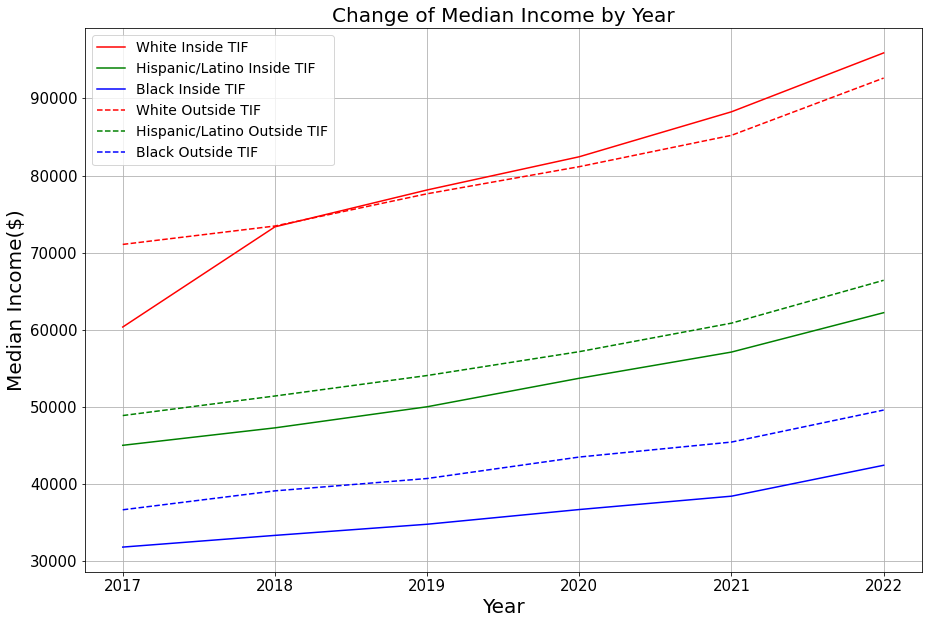

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))

plt.title("Change of Median Income by Year", fontsize = 20)

plt.plot(Inside_TIF_Result.columns, Inside_TIF_Result.iloc[1], label='White Inside TIF', c = 'r')
plt.plot(Inside_TIF_Result.columns, Inside_TIF_Result.iloc[2], label='Hispanic/Latino Inside TIF', c = 'g')
plt.plot(Inside_TIF_Result.columns, Inside_TIF_Result.iloc[0], label='Black Inside TIF', c = 'b')

plt.plot(Outside_TIF_Result.columns, Outside_TIF_Result.iloc[1],label='White Outside TIF', c = 'r', linestyle = 'dashed')
plt.plot(Outside_TIF_Result.columns, Outside_TIF_Result.iloc[2],label='Hispanic/Latino Outside TIF', c = 'g', linestyle = 'dashed')
plt.plot(Outside_TIF_Result.columns, Outside_TIF_Result.iloc[0],label='Black Outside TIF', c = 'b', linestyle ='dashed')

plt.xlabel('Year', fontsize = 20)
plt.ylabel('Median Income($)', fontsize = 20)
plt.xticks(fontsize = 15); plt.yticks(fontsize = 15)
plt.legend(fontsize = 14)
plt.grid()
plt.show()